In [1]:
import warnings
warnings.filterwarnings("ignore")

from scipy.integrate import solve_ivp
from pyomo.environ import *
from pyomo.dae import DerivativeVar, ContinuousSet
import matplotlib.pyplot as plt
from time import time
import pandas as pd
import numpy as np
import cyipopt

# CSTR Description

The model of a constant hold-up, jacketed CSTR carrying out an exothermic first-order reaction A-->B is given as follows:

$$\frac{dC}{dt}=\frac{Q}{V}(C_i-C)-kC$$

$$\frac{dT}{dt}=\frac{Q}{V}(T_i-T)-\frac{\Delta H_r kC}{\rho C_p}-\frac{UA}{\rho C_p V}(T-T_c)$$

$$\frac{dT_c}{dt}=\frac{Q_c}{V_c}(T_{ci}-T_c)+\frac{UA}{\rho_c C_{pc} V_c}(T-T_c)$$

The inputs are $\mathbf{u}=[C_i, T_i, Q_c]$ and the outputs are $\mathbf{y}=[C, T, T_c]$

Other constants are as follows:

|Parameter       |Description                 |Value            |Units     |
|----------------|----------------------------|-----------------|----------|
|$Q$             |Inlet Flow rate             |$100.0$          |L/min     |
|$V$             |Tank Volume                 |$150.0$          |L         |
|$V_c$           |Jacket Volume               |$10.0$           |L         |
|$\Delta H_r$    |Heat of reaction            |$-2\mathrm{e}5$  |cal/mol   |
|$UA$            |Heat transfer coefficient   |$7.0\mathrm{e}5$ |cal/min/K |
|$k_0$           |Arrhenius factor            |$7.2\mathrm{e}10$|1/min     |
|$E/R$           |Activation Energy           |$1\mathrm{e}4$   |K         |
|$\rho, \rho_{c}$|Density                     |$1000$           |g/L       |
|$C_p, C_{pc}$   |Heat capacity               |$1.0$            |cal/g/K   |   

Reference: Pilario and Cao (2018). Canonical Variate Dissimilarity Analysis for Process Incipient Fault Detection. IEEE Trans. on Industrial Informatics, 14 (12), 5308-5315.

# Rolling Horizon Simulation without Control

In [24]:
def solve_model(ti, tf, a_data, b_data, Qc_data, Ci_data, Ti_data, init_data):

    cstr = ConcreteModel()

    cstr.ti = Param(initialize=ti)
    cstr.tf = Param(initialize=tf)
    cstr.t = ContinuousSet(bounds=(cstr.ti,cstr.tf))

    # Parameters
    V   = 150     # L, Tank volume
    Vc  = 10      # L, Jacket volume
    dH  = -2.0e5  # cal/mol, Heat of rxn
    UA  = 7.0e5   # cal/min/K, heat transfer coeff.
    k0  = 7.2e10  # 1/min, pre-exponential factor
    ER  = 1.0e4   # K, Activation energy
    rC  = 1.0e3   # cal/L/K, density * heat capacity
   
    # States
    cstr.C  = Var(cstr.t, initialize=0.1, domain=NonNegativeReals)
    cstr.T  = Var(cstr.t, initialize=430.882699002514)
    cstr.Tc = Var(cstr.t, initialize=416.723084574301)
    
    # Inputs and Disturbances
    cstr.Q   = Param(cstr.t, default=100)  # L/min, Inlet flow rate
    cstr.Tci = Param(cstr.t, default=350)  # K, Inlet coolant temp.
    
    cstr.a = Param(cstr.t, mutable=True) # Catalyst activity
    cstr.b = Param(cstr.t, mutable=True) # Fouling extent
    
    cstr.Qc = Param(cstr.t, mutable=True)  # Input
    cstr.Ci = Param(cstr.t, mutable=True)  # Input
    cstr.Ti = Param(cstr.t, mutable=True)  # Input
    
    # Setup derivative vars for states
    cstr.dCdt = DerivativeVar(cstr.C, initialize=init_data['dCdt'])
    cstr.dTdt = DerivativeVar(cstr.T, initialize=init_data['dTdt'])
    cstr.dTcdt = DerivativeVar(cstr.Tc, initialize=init_data['dTcdt'])

    # Set an objective
    cstr.obj = Objective(expr=1)
    
    def dCdt(m, i):
        return m.dCdt[i] == m.Q[i]/V*(m.Ci[i] - m.C[i]) - \
                            m.a[i] * k0*exp(-ER/m.T[i]) * m.C[i]
    
    def dTdt(m, i):
        return m.dTdt[i] == m.Q[i]/V*(m.Ti[i] - m.T[i]) - \
                            m.a[i] * k0*exp(-ER/m.T[i]) * m.C[i] * dH/rC - \
                            m.b[i] * UA/rC/V*(m.T[i] - m.Tc[i])
    
    def dTcdt(m, i):
        return m.dTcdt[i] == m.Qc[i]/Vc*(m.Tci[i] - m.Tc[i]) + \
                             m.b[i] * UA/rC/Vc*(m.T[i] - m.Tc[i])
    
    cstr.z1dot = Constraint(cstr.t, rule=dCdt)
    cstr.z2dot = Constraint(cstr.t, rule=dTdt)
    cstr.z3dot = Constraint(cstr.t, rule=dTcdt)

    def _init(m):
        yield m.C[cstr.ti] == init_data['C']
        yield m.T[cstr.ti] == init_data['T']
        yield m.Tc[cstr.ti] == init_data['Tc']
    
    cstr.initcon = ConstraintList(rule=_init)

    # Discretize using collocation
    discretizer = TransformationFactory('dae.collocation')
    discretizer.apply_to(cstr, nfe=50, ncp=3, scheme='LAGRANGE-RADAU')

    # Step change data
    timepoints = list(cstr.t)
    if cstr.ti.value == 0:
        a_data[0] = 1.
        b_data[0] = 1.
        Qc_data[0] = 148.5502
        Ci_data[0] = 1.
        Ti_data[0] = 350.
        
    for i, t in enumerate(timepoints):
        pos = np.argwhere(t>=i_data)[-1]
        cstr.a[t] = a_data[pos][0]
        cstr.b[t] = b_data[pos][0]
        cstr.Qc[t] = Qc_data[pos][0]
        cstr.Ci[t] = Ci_data[pos][0]
        cstr.Ti[t] = Ti_data[pos][0]

    # Solve using Pyomo IPOPT
    solver = SolverFactory('cyipopt')
    res = solver.solve(cstr)
    
    model_vars = cstr.component_map(ctype=Var)
    model_params = cstr.component_map(ctype=Param)

    s_list = []
    col_list = []
    ctr = 1
    for k in model_vars.keys():
        v = model_vars[k]
        s = pd.Series(v.extract_values(), 
                      index=v.extract_values().keys())
        s.sort_index(inplace=True)
        s_list.append(s)
        col_list.append(v.name)
        ctr += 1

    for k in model_params.keys():
        v = model_params[k]
        if v.name == 'Qc' or v.name == 'Ci' or v.name == 'Ti':
            s = pd.Series(v.extract_values(), 
                          index=v.extract_values().keys())
            s.sort_index(inplace=True)
            s_list.append(s)
            col_list.append(v.name)
            ctr += 1

    cstr_df = pd.concat(s_list, axis=1)
    cstr_df.columns = col_list
    return cstr_df, res
    
np.random.seed(2)
i_data = np.arange(0, 400, 50) # start, last, increment
a_data = np.ones(i_data.shape[0])
b_data = np.ones(i_data.shape[0])
Qc_data = (np.random.rand(i_data.shape[0])-0.5)*5 + 148.5502
Ci_data = (np.random.rand(i_data.shape[0])-0.5)*0.1 + 1.
Ti_data = (np.random.rand(i_data.shape[0])-0.5)*5 + 350.

init_data = {'C':0.1,  
             'T':430.882699002514,  
             'Tc':416.723084574301,
             'dCdt':0, 'dTdt':0, 'dTcdt':0}

# Initialize the data frame
cstr_df = pd.DataFrame(columns=['C', 'T', 'Tc', 'dCdt', 'dTdt', 
                                'dTcdt', 'Qc', 'Ci', 'Ti'])

for j in np.arange(0, 400, 50): # start, last, increment
    
    # Simulate the model within time period
    temp_df, res = solve_model(j, j+50, a_data, b_data, Qc_data, Ci_data, Ti_data, init_data)
    print(f"Time: {j} min to {j+50} min")
    print(f"Status: {res.Solver.status}")
    
    # Save the last condition as the next initial condition
    for k in init_data.keys():
        init_data[k] = temp_df.iloc[-1][k]

    # Append temp_df after evap_df
    if j < 350:
        cstr_df = pd.concat([cstr_df, temp_df.iloc[:-1,:]], axis=0)
    else:
        cstr_df = pd.concat([cstr_df, temp_df], axis=0)

Time: 0 min to 50 min
Status: ok
Time: 50 min to 100 min
Status: ok
Time: 100 min to 150 min
Status: ok
Time: 150 min to 200 min
Status: ok
Time: 200 min to 250 min
Status: ok
Time: 250 min to 300 min
Status: ok
Time: 300 min to 350 min
Status: ok
Time: 350 min to 400 min
Status: ok


In [20]:
cstr_df.shape

(1201, 9)

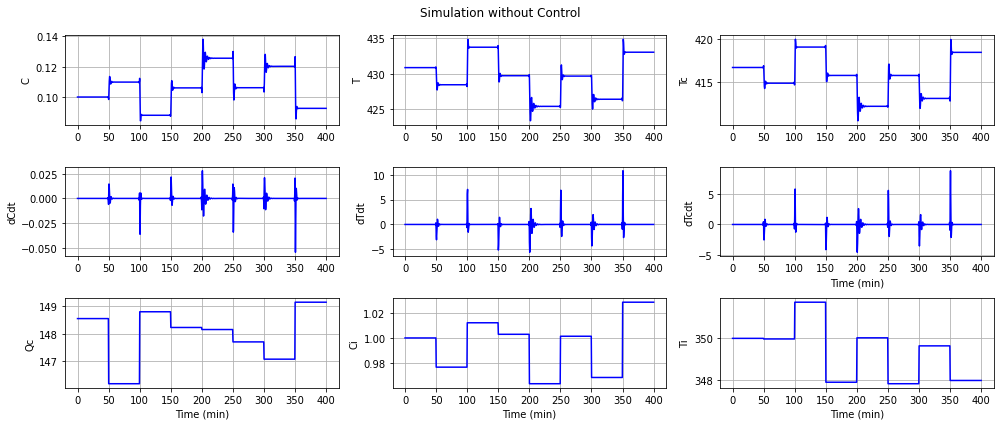

In [25]:
ctr = 1
plt.figure(figsize=(14, 6))
for k in cstr_df.columns:
    plt.subplot(3, 3, ctr)
    plt.plot(cstr_df[k].index, cstr_df[k].values,'b-')
    plt.ylabel(k)
    if ctr > 5:
        plt.xlabel('Time (min)')
    plt.grid()
    ctr += 1
    
plt.suptitle('Simulation without Control')
plt.tight_layout()
plt.show()

In [22]:
cstr_df.head(10)

,C,T,Tc,dCdt,dTdt,dTcdt,Qc,Ci,Ti
0.000000,0.1,430.882699,416.723085,-1.454392e-14,-7.958079e-13,2.541620e-04,148.5502,1.0,350.0
0.155051,0.1,430.882702,416.723090,-5.395416e-08,1.987463e-05,2.760847e-05,148.5502,1.0,350.0
0.644949,0.1,430.882713,416.723099,-1.083963e-07,2.131900e-05,1.322602e-05,148.5502,1.0,350.0
1.000000,0.1,430.882718,416.723103,-7.101441e-08,9.609047e-06,1.538042e-05,148.5502,1.0,350.0
1.155051,0.1,430.882720,416.723104,-4.593310e-08,4.760036e-06,4.545103e-06,148.5502,1.0,350.0
1.644949,0.1,430.882719,416.723104,1.151306e-08,-4.786769e-06,-3.978618e-06,148.5502,1.0,350.0
2.000000,0.1,430.882717,416.723103,2.720767e-08,-5.868380e-06,-4.671476e-06,148.5502,1.0,350.0
2.155051,0.1,430.882716,416.723102,2.630140e-08,-4.997251e-06,-4.173805e-06,148.5502,1.0,350.0
2.644949,0.1,430.882715,416.723101,1.196505e-08,-1.317434e-06,-1.163642e-06,148.5502,1.0,350.0
3.000000,0.1,430.882715,416.723101,4.486129e-11,7.959085e-07,6.234938e-07,148.5502,1.0,350.0


# Setpoint Tracking MPC

Now, we take $Q_c$ as the manipulated variable and our objective is to track a new setpoint of 0.05 mol/L for the outlet concentration, $C$ over a prediction horizon of 10 min. Allow changes in $Q_c$ every 1 min only. Keep $C_i$ and $T_i$ constant.

In [32]:
pred_hor = 10
i_data = np.arange(0, pred_hor) # start, last
nvar = i_data.shape[0]

a_data = np.ones(nvar)
b_data = np.ones(nvar)
Ci_data = np.zeros(nvar) + 1.
Ti_data = np.zeros(nvar) + 350.
init_data = {'C':0.1,  
             'T':430.882699002514,  
             'Tc':416.723084574301,
             'dCdt':0, 'dTdt':0, 'dTcdt':0}
cstr_df = pd.DataFrame(columns=['C', 'T', 'Tc', 'dCdt', 'dTdt', 
                                    'dTcdt', 'Qc', 'Ci', 'Ti'])

class myMPC:
    def __init__(self, a_data, b_data, Ci_data, Ti_data, init_data):
        self.a_data = a_data
        self.b_data = b_data
        self.Ci_data = Ci_data
        self.Ti_data = Ti_data
        self.init_data = init_data
        
    def objective(self, v):
        v = v*100 + 148.5502
        cstr_df, res = solve_model(0, pred_hor, a_data, b_data, v,
                                   Ci_data, Ti_data, init_data)
        return sum((cstr_df['C']-0.05)**2)
    
    def gradient(self, v):
        g = np.zeros(v.shape)
        step = 1e-3
        for j in range(nvar):
            x_hi = v.copy()
            x_lo = v.copy()
            x_hi[j] = x_hi[j] + step
            x_lo[j] = x_lo[j] - step
            g[j] = (self.objective(x_hi) - self.objective(x_lo)) / (2*step)
        
        return g

start = time()
nlp = cyipopt.problem(n=nvar,
                      m=0,
                      problem_obj=myMPC(a_data, b_data, 
                                        Ci_data, Ti_data, init_data),
                      lb=-np.ones(nvar),
                      ub=np.ones(nvar))

init_guess = np.zeros(nvar)
nlp.addOption('tol', 1e-2)
#nlp.addOption('max_iter',2)
Qc_opt, info = nlp.solve(init_guess)

print(f"IPOPT took {time() - start:.4f} sec.")
print(info['status_msg'])

Qc_opt = Qc_opt*100 + 148.5502
cstr_df, res = solve_model(0, pred_hor, a_data, b_data, Qc_opt, Ci_data, Ti_data, init_data)
print(cstr_df.head(10))

IPOPT took 29.8638 sec.
b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
           C           T          Tc          dCdt          dTdt     dTcdt  \
0.00000  0.1  430.882699  416.723085 -1.458224e-14 -8.386774e-13  0.000254   
0.03101  0.1  430.882699  416.723087 -9.341172e-09  1.205687e-05  0.000061   
0.12899  0.1  430.882701  416.723089 -4.474029e-08  2.031456e-05  0.000001   
0.20000  0.1  430.882702  416.723090 -6.674024e-08  2.125508e-05  0.000033   
0.23101  0.1  430.882703  416.723091 -7.444869e-08  2.270581e-05  0.000022   
0.32899  0.1  430.882705  416.723093 -9.410771e-08  2.444274e-05  0.000019   
0.40000  0.1  430.882707  416.723094 -1.035735e-07  2.456533e-05  0.000021   
0.43101  0.1  430.882708  416.723095 -1.064623e-07  2.449353e-05  0.000020   
0.52899  0.1  430.882710  416.723097 -1.111725e-07  2.342654e-05  0.000019   
0.60000  0.1  430.882712  416.723098 -1.107907e-07  2.205521e-

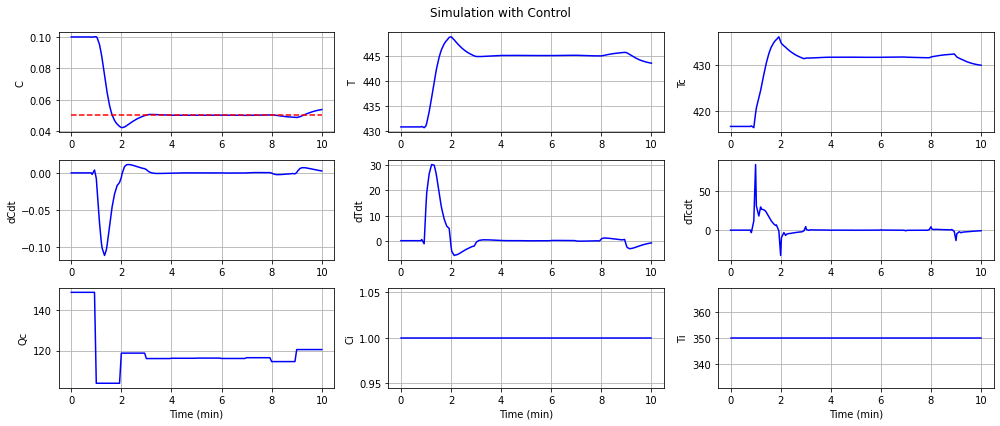

In [34]:
ctr = 1
plt.figure(figsize=(14, 6))
for k in cstr_df.columns:
    plt.subplot(3, 3, ctr)
    plt.plot(cstr_df[k].index, cstr_df[k].values,'b-')
    plt.ylabel(k)
    if ctr == 1:
        plt.plot([0, pred_hor], [0.05, 0.05], 'r--')
    if ctr > 6:
        plt.xlabel('Time (min)')
    plt.grid()
    ctr += 1
    
plt.suptitle('Simulation with Control')
plt.tight_layout()
plt.show()

# Perform Optimal Control with Fouling

In [44]:
pred_hor = 10
i_data = np.arange(0, pred_hor) # start, last
nvar = i_data.shape[0]

a_data = np.ones(nvar)
b_data = np.ones(nvar)
b_data[6:] = 0.5        # Fouling at 5 min
Ci_data = np.zeros(nvar) + 1.
Ti_data = np.zeros(nvar) + 350.
init_data = {'C':0.1,  
             'T':430.882699002514,  
             'Tc':416.723084574301,
             'dCdt':0, 'dTdt':0, 'dTcdt':0}
cstr_df = pd.DataFrame(columns=['C', 'T', 'Tc', 'dCdt', 'dTdt', 
                                    'dTcdt', 'Qc', 'Ci', 'Ti'])

start = time()
nlp = cyipopt.problem(n=nvar,
                      m=0,
                      problem_obj=myMPC(a_data, b_data, 
                                        Ci_data, Ti_data, init_data),
                      lb=-np.ones(nvar),
                      ub=np.ones(nvar))

init_guess = np.zeros(nvar)
nlp.addOption('tol', 1e-2)
#nlp.addOption('max_iter',2)
Qc_opt, info = nlp.solve(init_guess)

print(f"IPOPT took {time() - start:.4f} sec.")
print(info['status_msg'])

Qc_opt = Qc_opt*100 + 148.5502
cstr_df, res = solve_model(0, pred_hor, a_data, b_data, Qc_opt, Ci_data, Ti_data, init_data)
print(cstr_df.head(10))

IPOPT took 27.3043 sec.
b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
           C           T          Tc          dCdt          dTdt     dTcdt  \
0.00000  0.1  430.882699  416.723085 -1.458683e-14 -6.635714e-13  0.000254   
0.03101  0.1  430.882699  416.723087 -9.341172e-09  1.205687e-05  0.000061   
0.12899  0.1  430.882701  416.723089 -4.474028e-08  2.031456e-05  0.000001   
0.20000  0.1  430.882702  416.723090 -6.674024e-08  2.125508e-05  0.000033   
0.23101  0.1  430.882703  416.723091 -7.444870e-08  2.270581e-05  0.000022   
0.32899  0.1  430.882705  416.723093 -9.410771e-08  2.444274e-05  0.000019   
0.40000  0.1  430.882707  416.723094 -1.035735e-07  2.456533e-05  0.000021   
0.43101  0.1  430.882708  416.723095 -1.064623e-07  2.449353e-05  0.000020   
0.52899  0.1  430.882710  416.723097 -1.111725e-07  2.342654e-05  0.000019   
0.60000  0.1  430.882712  416.723098 -1.107907e-07  2.205521e-

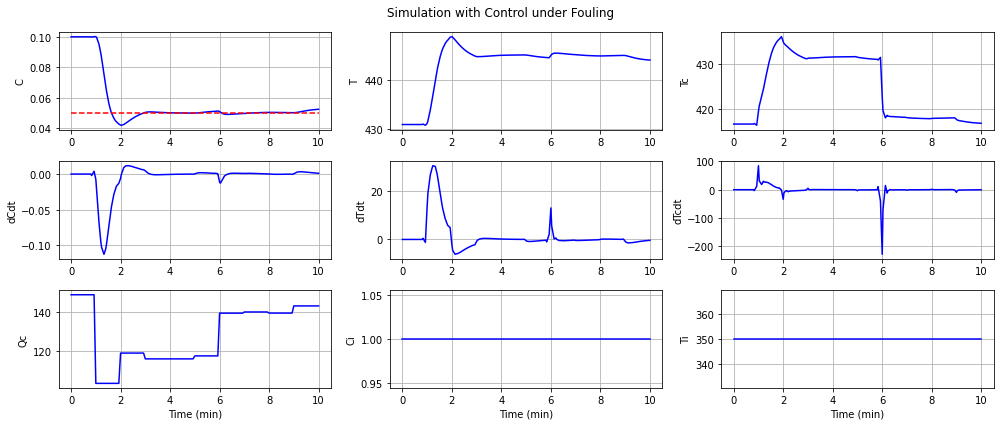

In [45]:
ctr = 1
plt.figure(figsize=(14, 6))
for k in cstr_df.columns:
    plt.subplot(3, 3, ctr)
    plt.plot(cstr_df[k].index, cstr_df[k].values,'b-')
    plt.ylabel(k)
    if ctr == 1:
        plt.plot([0, pred_hor], [0.05, 0.05], 'r--')
    if ctr > 6:
        plt.xlabel('Time (min)')
    plt.grid()
    ctr += 1
    
plt.suptitle('Simulation with Control under Fouling')
plt.tight_layout()
plt.show()

# Perform Optimal Control with Catalyst Decay

In [46]:
pred_hor = 10
i_data = np.arange(0, pred_hor) # start, last
nvar = i_data.shape[0]

a_data = np.ones(nvar)
b_data = np.ones(nvar)
a_data[6:] = 0.5        # Catalyst decay at 5 min
Ci_data = np.zeros(nvar) + 1.
Ti_data = np.zeros(nvar) + 350.
init_data = {'C':0.1,  
             'T':430.882699002514,  
             'Tc':416.723084574301,
             'dCdt':0, 'dTdt':0, 'dTcdt':0}
cstr_df = pd.DataFrame(columns=['C', 'T', 'Tc', 'dCdt', 'dTdt', 
                                    'dTcdt', 'Qc', 'Ci', 'Ti'])

start = time()
nlp = cyipopt.problem(n=nvar,
                      m=0,
                      problem_obj=myMPC(a_data, b_data, 
                                        Ci_data, Ti_data, init_data),
                      lb=-np.ones(nvar),
                      ub=np.ones(nvar))

init_guess = np.zeros(nvar)
nlp.addOption('tol', 1e-2)
#nlp.addOption('max_iter',2)
Qc_opt, info = nlp.solve(init_guess)

print(f"IPOPT took {time() - start:.4f} sec.")
print(info['status_msg'])

Qc_opt = Qc_opt*100 + 148.5502
cstr_df, res = solve_model(0, pred_hor, a_data, b_data, Qc_opt, Ci_data, Ti_data, init_data)
print(cstr_df.head(10))

IPOPT took 58.3619 sec.
b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
           C           T          Tc          dCdt          dTdt     dTcdt  \
0.00000  0.1  430.882699  416.723085 -1.453743e-14 -7.174234e-13  0.000254   
0.03101  0.1  430.882699  416.723087 -9.341172e-09  1.205687e-05  0.000061   
0.12899  0.1  430.882701  416.723089 -4.474029e-08  2.031456e-05  0.000001   
0.20000  0.1  430.882702  416.723090 -6.674024e-08  2.125508e-05  0.000033   
0.23101  0.1  430.882703  416.723091 -7.444870e-08  2.270581e-05  0.000022   
0.32899  0.1  430.882705  416.723093 -9.410771e-08  2.444274e-05  0.000019   
0.40000  0.1  430.882707  416.723094 -1.035735e-07  2.456533e-05  0.000021   
0.43101  0.1  430.882708  416.723095 -1.064623e-07  2.449353e-05  0.000020   
0.52899  0.1  430.882710  416.723097 -1.111725e-07  2.342654e-05  0.000019   
0.60000  0.1  430.882712  416.723098 -1.107907e-07  2.205521e-

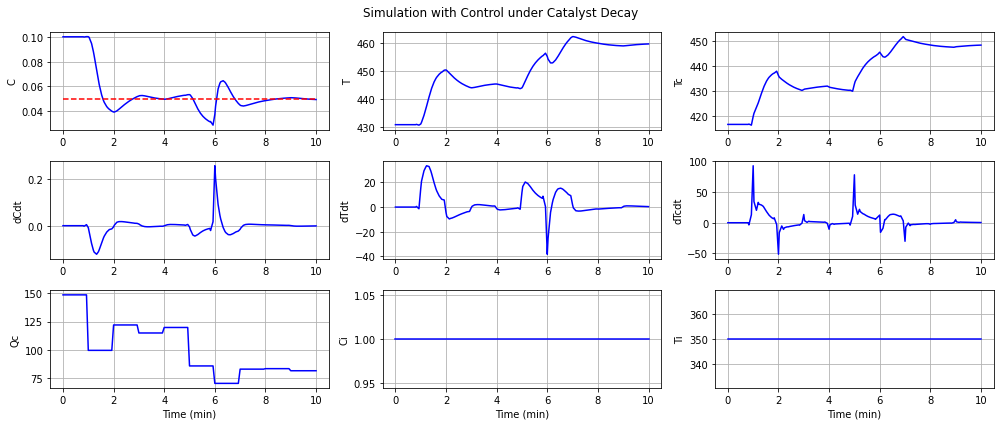

In [47]:
ctr = 1
plt.figure(figsize=(14, 6))
for k in cstr_df.columns:
    plt.subplot(3, 3, ctr)
    plt.plot(cstr_df[k].index, cstr_df[k].values,'b-')
    plt.ylabel(k)
    if ctr == 1:
        plt.plot([0, pred_hor], [0.05, 0.05], 'r--')
    if ctr > 6:
        plt.xlabel('Time (min)')
    plt.grid()
    ctr += 1
    
plt.suptitle('Simulation with Control under Catalyst Decay')
plt.tight_layout()
plt.show()